# Blu LeBlanc
# Unsupervised Machine Learning Final Project
Project Idea: The purpose of this project is to analyze customer purhcasing behavior, demographics, and engagement patterns for clustering. The goal will be to practice using various unsupervised Machine Learning models and techniques for clustering and compare them. We also want to get basic insights from our clustering about customer behavior.
# Library
Load all necessary libraries for EDA and clustering models
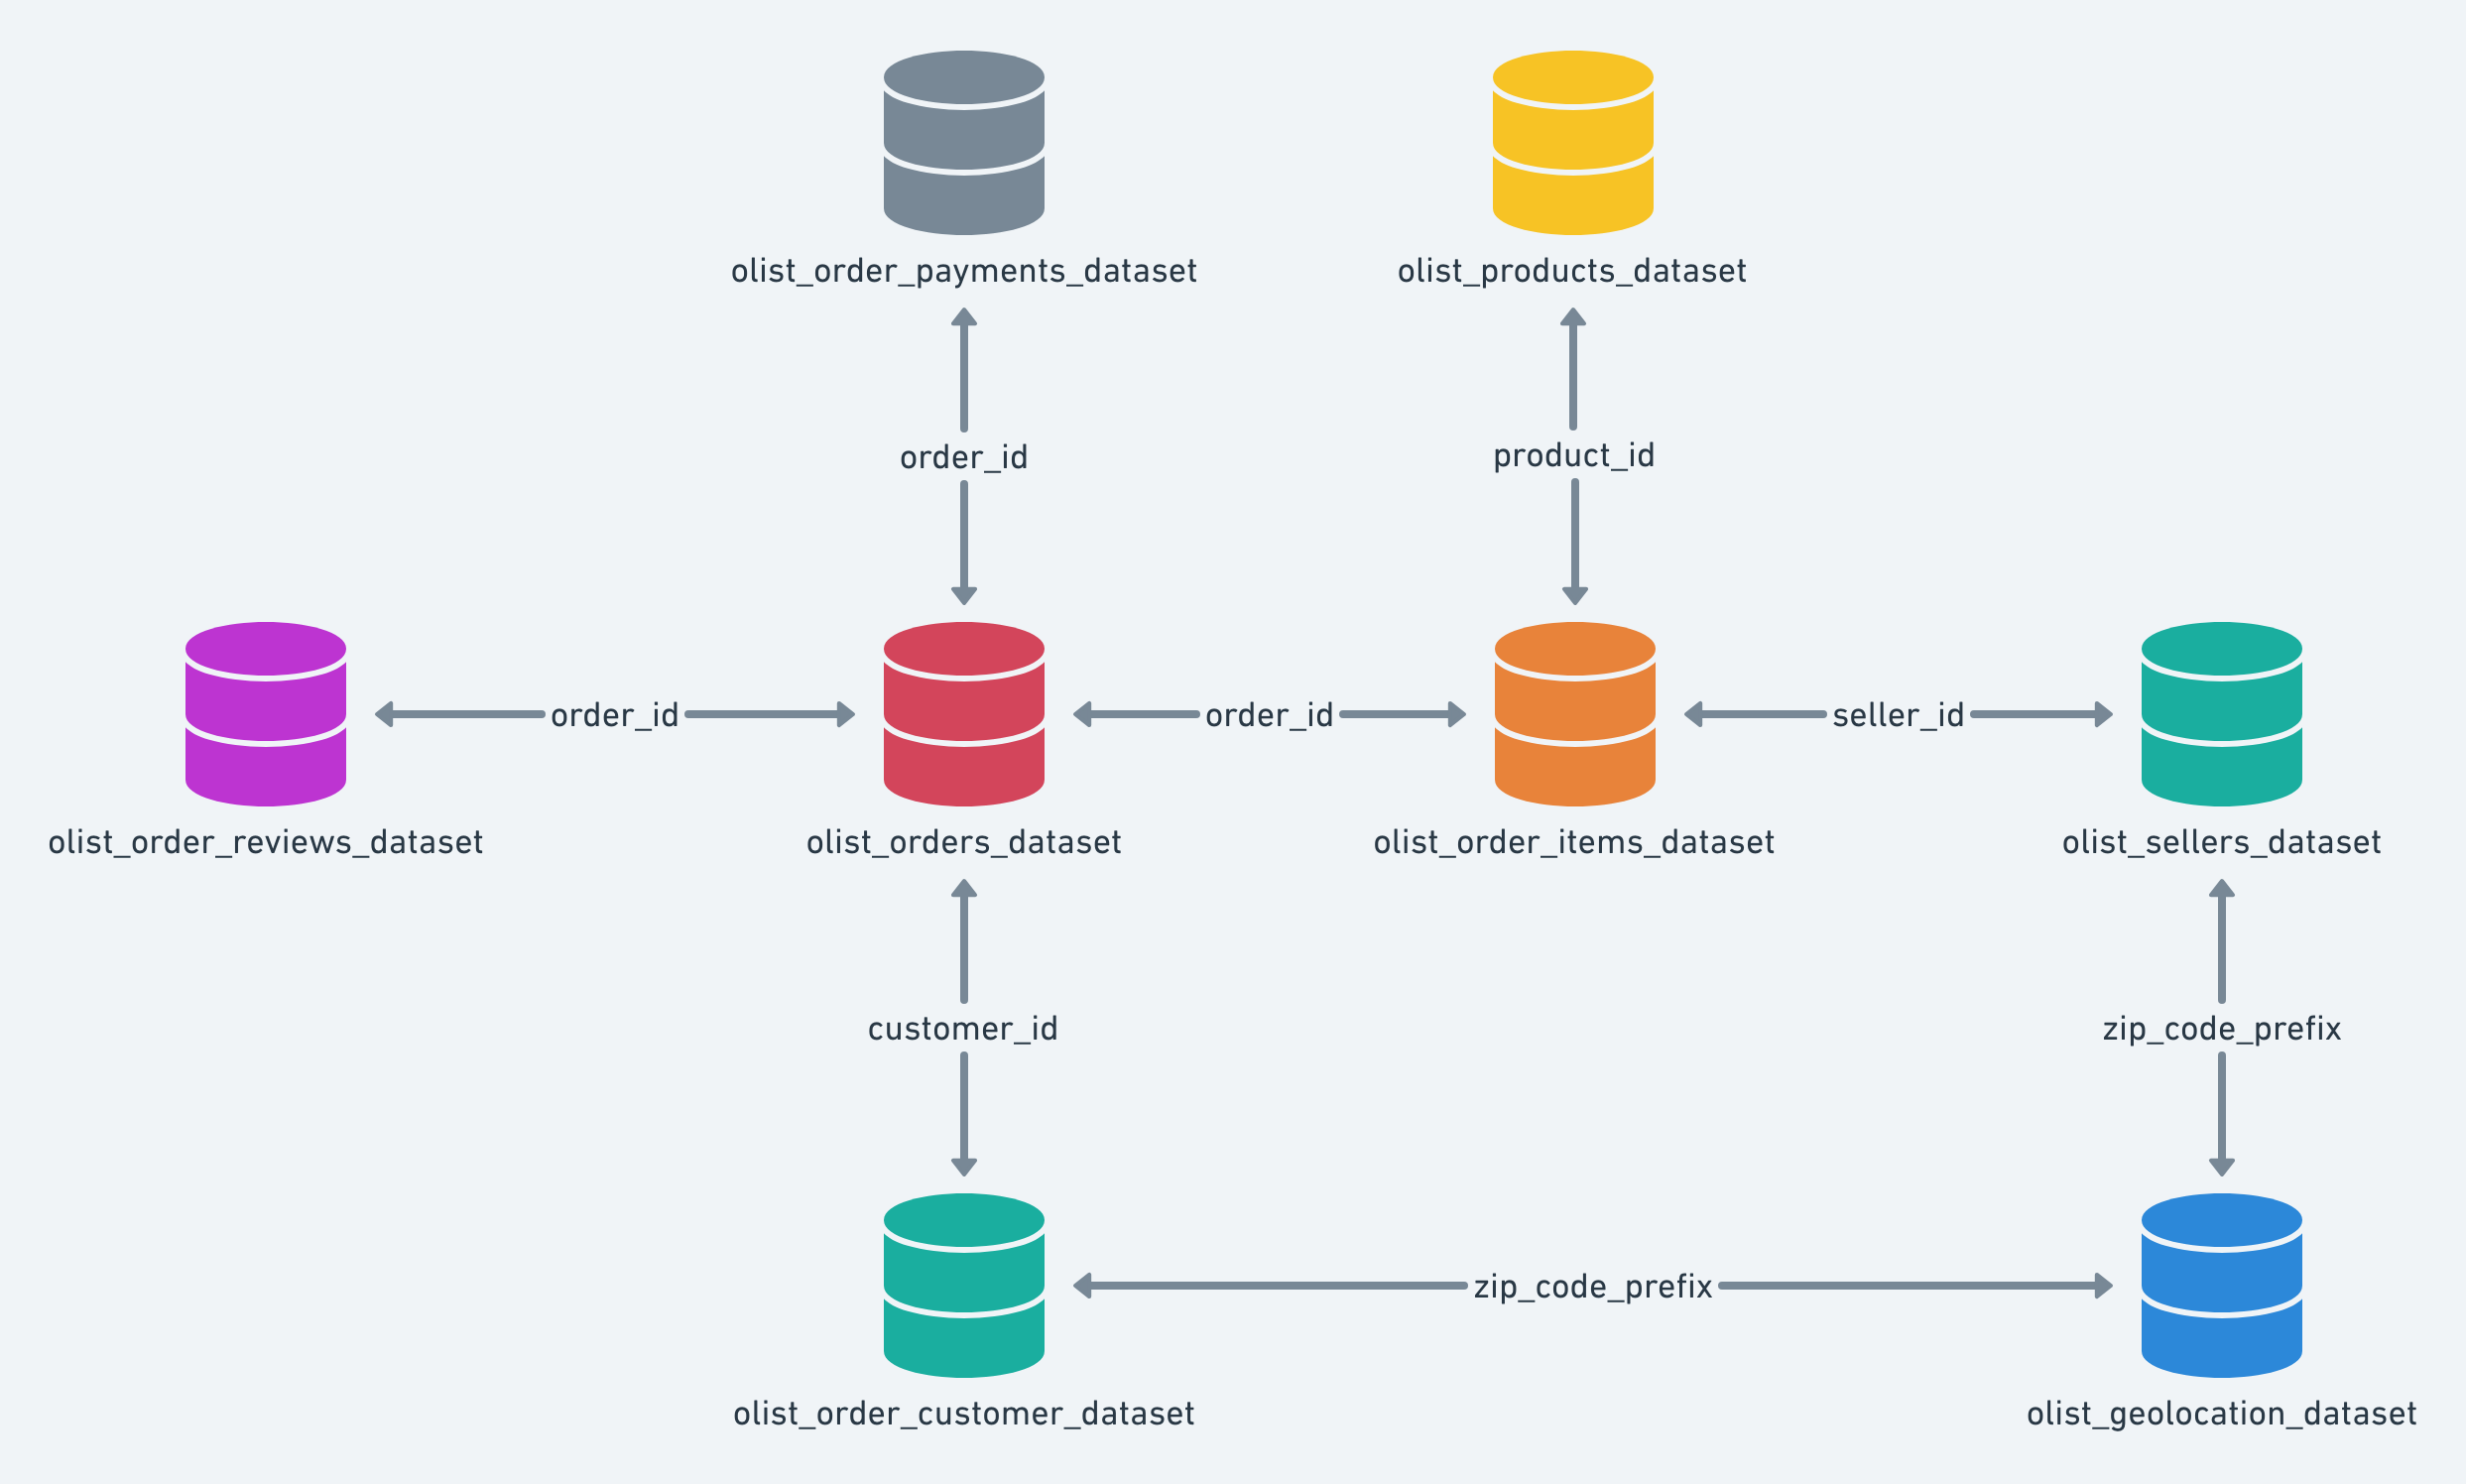
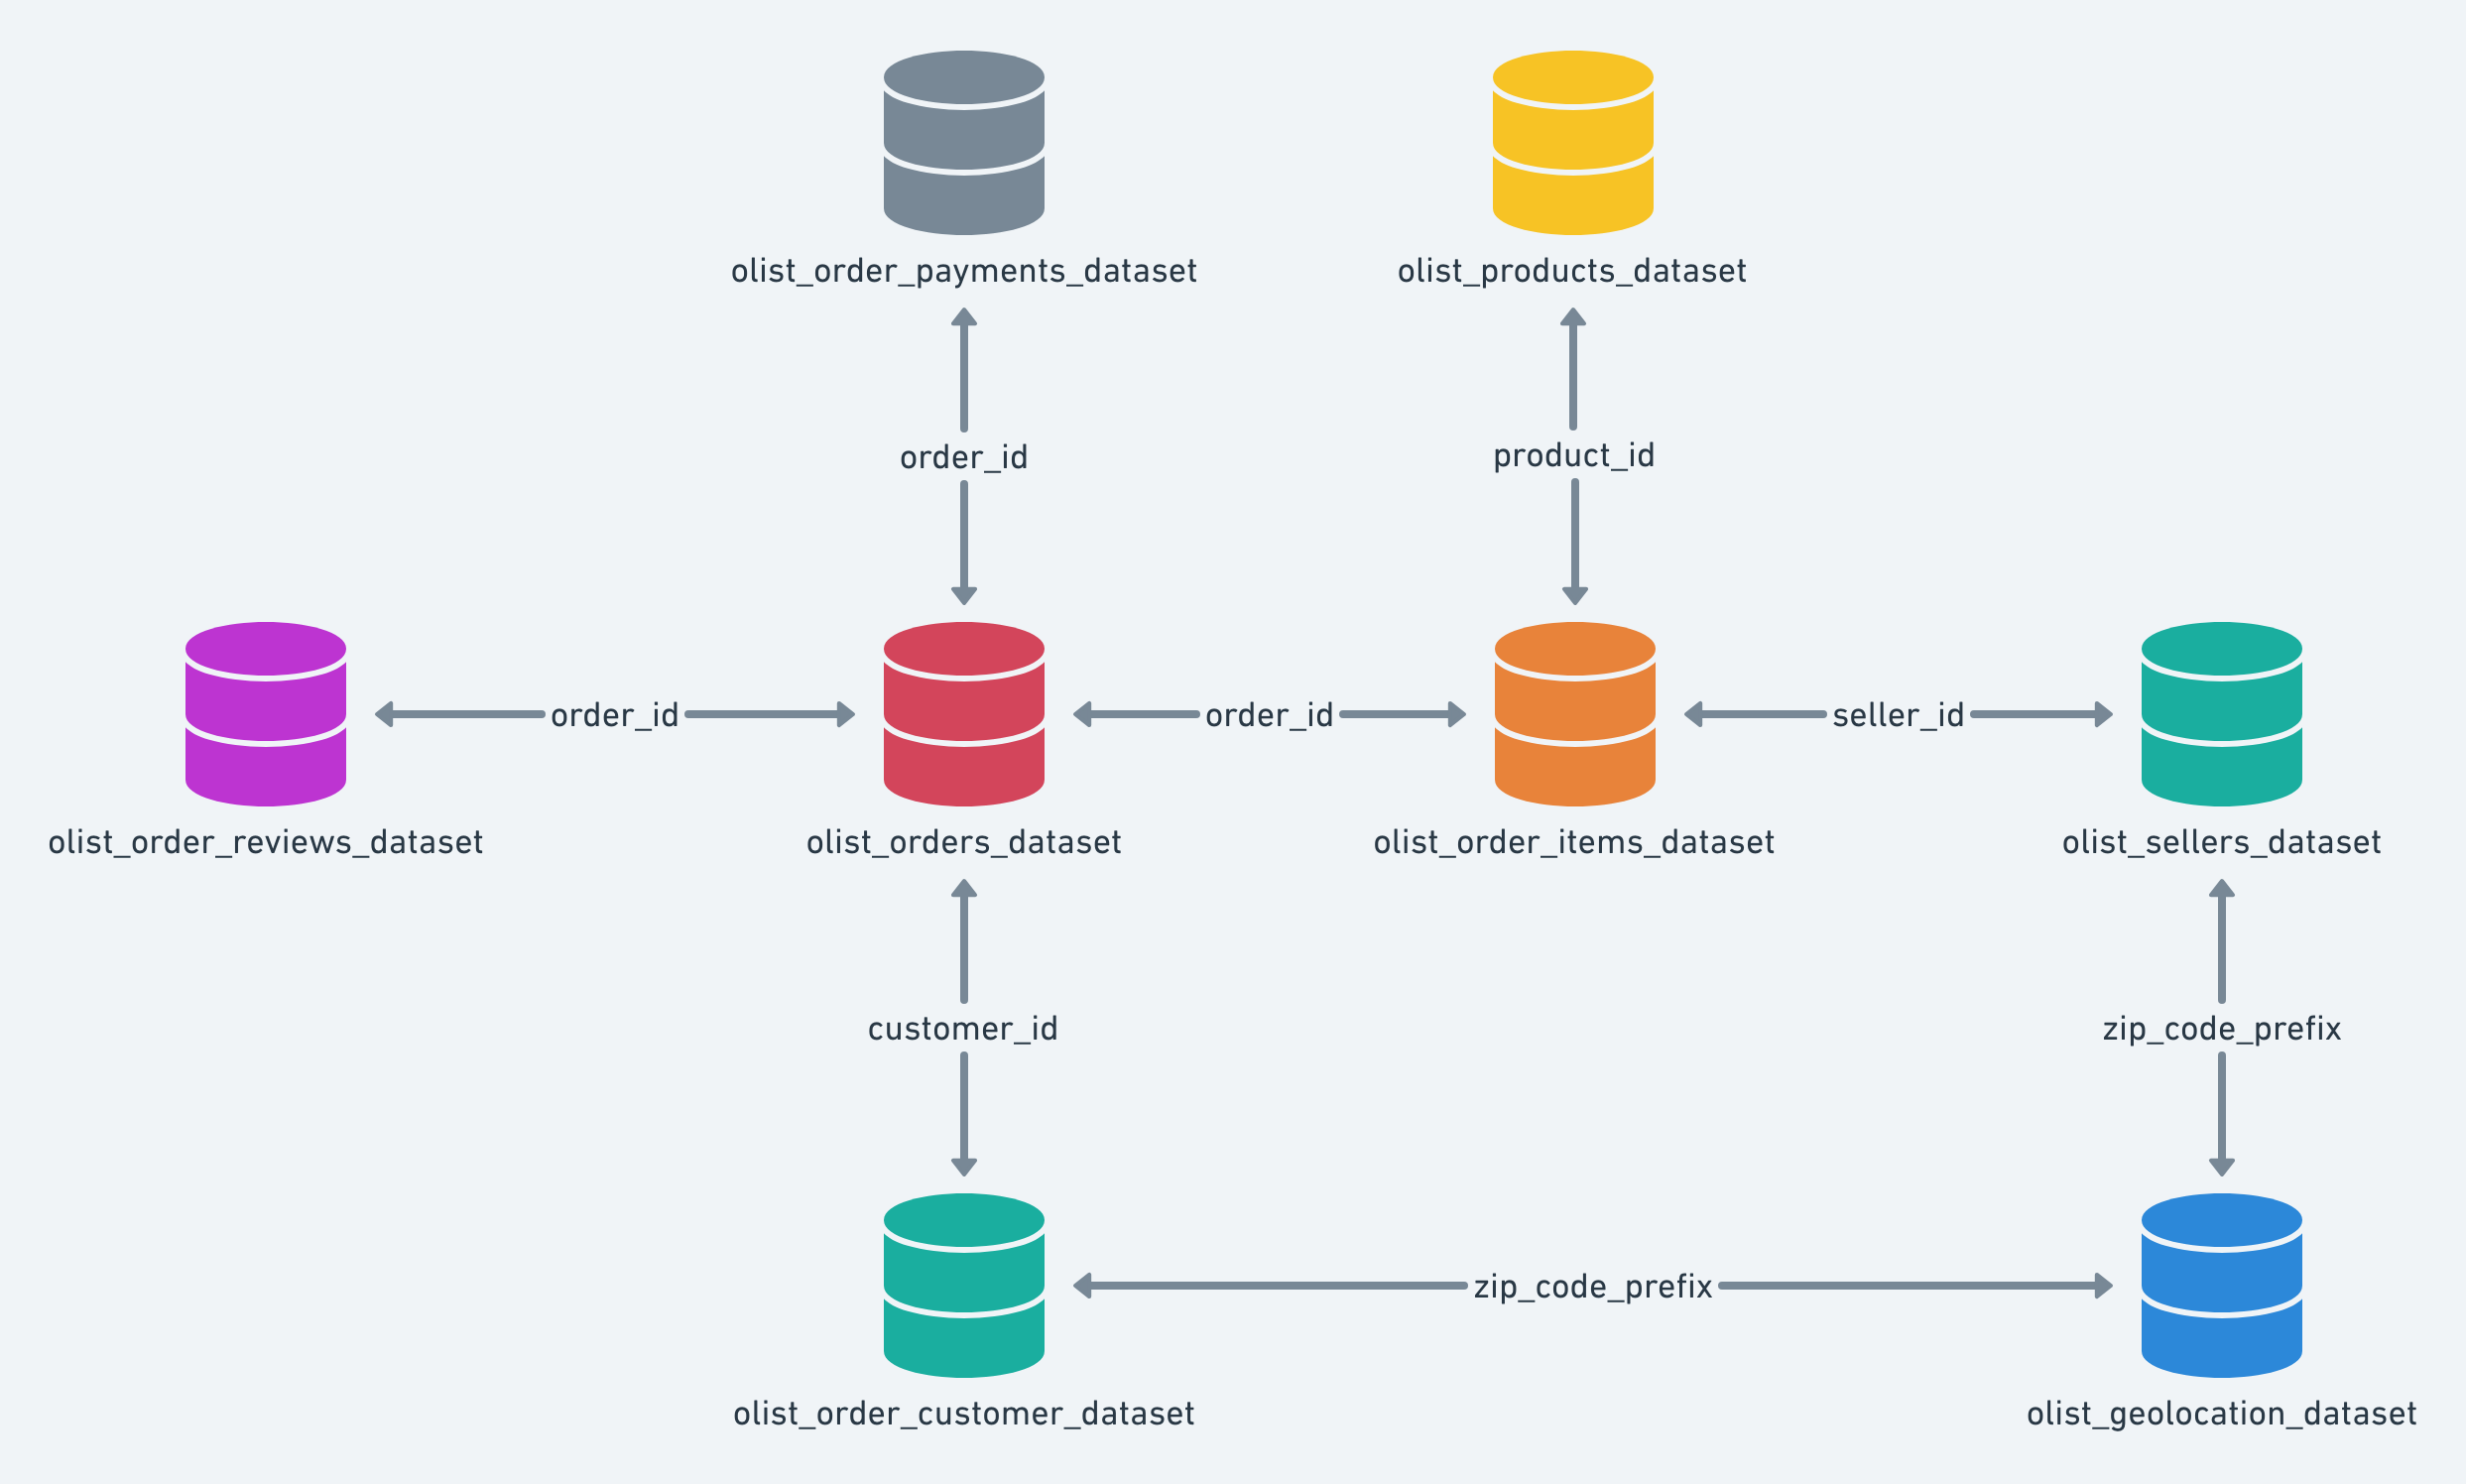

In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

## Dataset
Magioli, Francisco. Brazilian E-Commerce Public Dataset by Olist. (Version 2). Brazil: Olist, 2021. Kaggle. <https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data>

Found public ecommerce dataset of orders made on Olist, one of the largest Brazilian department stores. The dataset has information of 100k orders conducted from 2016 - 2018. The data schema provided by the kaggle documentation is provided below:
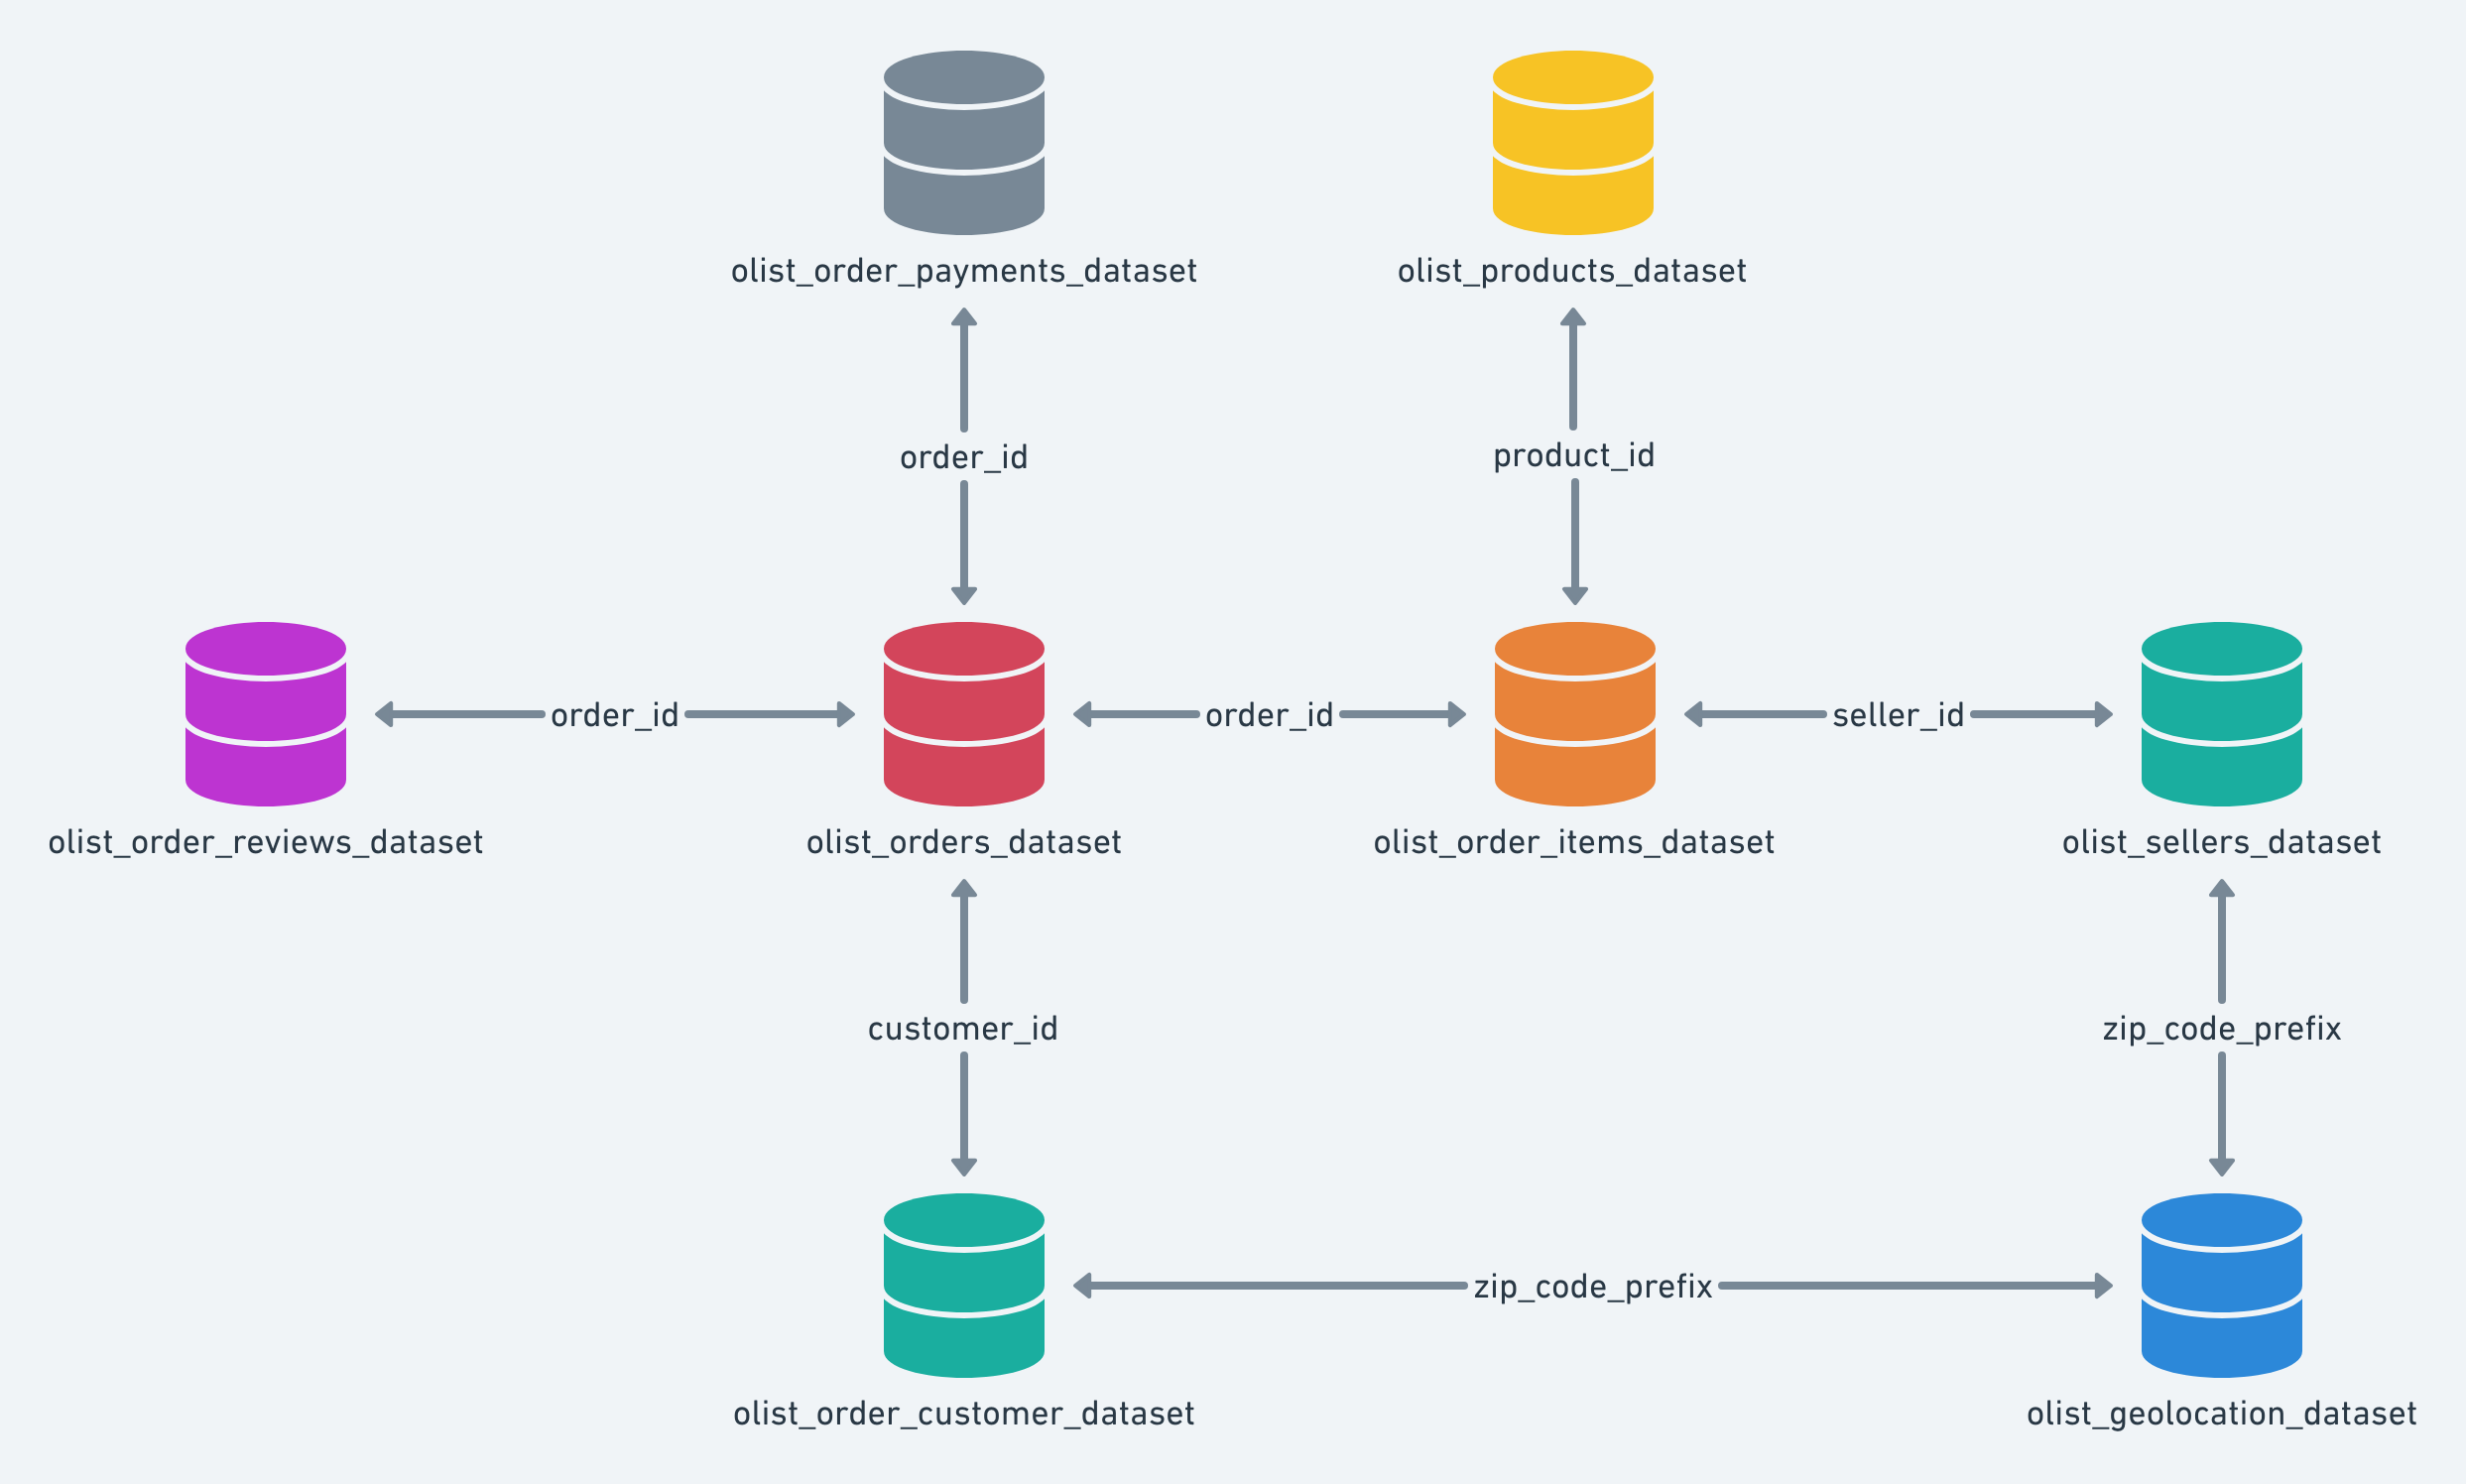

We see the dataset consists of multiple tables: 

olist_customers_dataset.csv: Customer information with location

olist_orders_dataset.csv: Order information

olist_order_items_dataset.csv: Items purchased in each order

olist_products_dataset.csv: Product Information

olist_order_payments_dataset.csv: Payment Information

olist_order_reviews_dataset.csv: Customer Reviews

olist_sellers_dataset.csv: Seller Information

olist_geolocation_dataset.csv: Geolocation data

Let's load in all of our relevant datasets. We do not need seller information or geolocation data for our purpose.
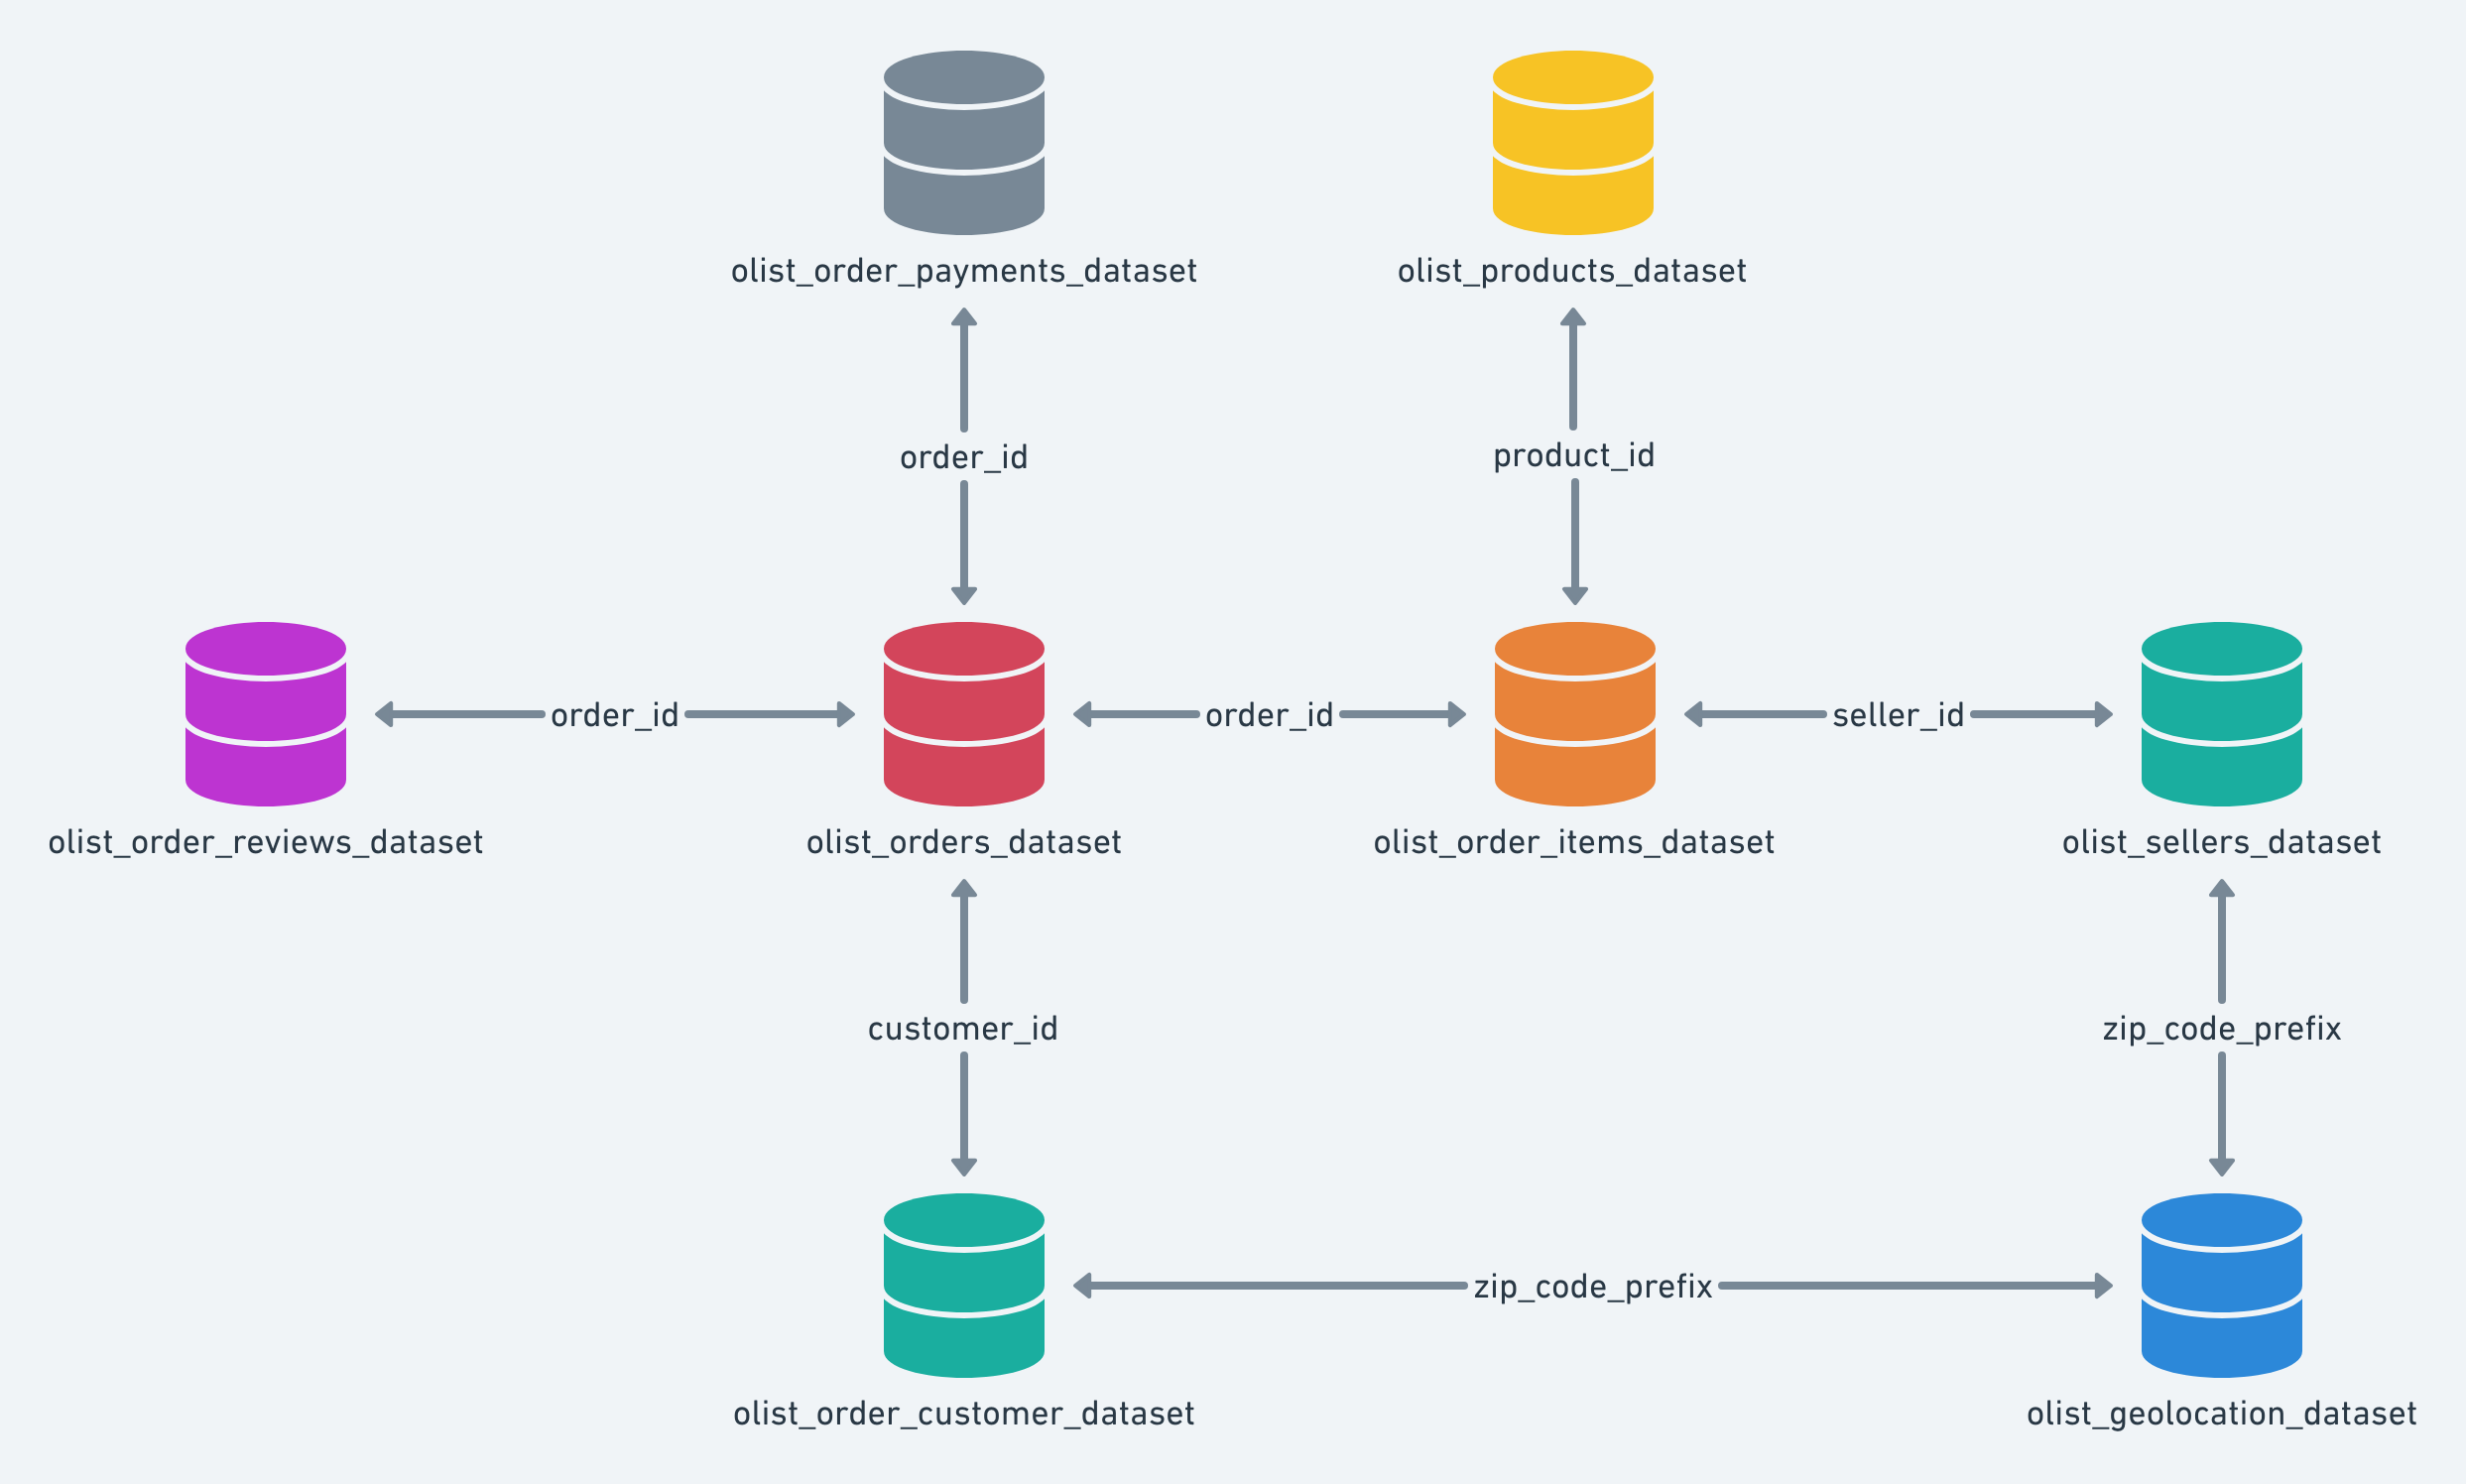

In [2]:
# load data
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')

# view of customers
print(customers.shape)
customers.head

(99441, 5)


<bound method NDFrame.head of                             customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          cust

## EDA
### Initial EDA

We will perform extensive Exploratory Data Analysis to set up for clustering models. First let's observe the datasets and check for missing values

In [3]:
# create list of datasets
datasets = {
    'customers': customers,
    'orders': orders,
    'order_items': order_items,
    'products': products,
    'payments': payments,
    'reviews': reviews
}

# check for missing values
for name, df in datasets.items():
    print(f"\n--- {name.upper()} DATASET ---")
    print(f"Shape: {df.shape}")
    print("Data types:")
    print(df.dtypes)
    print("Missing values:")
    print(df.isnull().sum())


# check statistics
for name, df in datasets.items():
    print(f"\n--- {name.upper()} STATISTICS ---")
    print(df.describe())
    print("-" * 50)


--- CUSTOMERS DATASET ---
Shape: (99441, 5)
Data types:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
Missing values:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

--- ORDERS DATASET ---
Shape: (99441, 8)
Data types:
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
Missing values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at  

The missing values for product_category_name (610 missing) could impact clustering if we use category-based features. For missing products, we will replace them with unkown. For missing reviews, we will flag them as has_comment or not.

In [4]:
# handle missing values
# orders missing
orders['is_approved'] = ~orders['order_approved_at'].isna()
orders['is_delivered_to_carrier'] = ~orders['order_delivered_carrier_date'].isna()
orders['is_delivered_to_customer'] = ~orders['order_delivered_customer_date'].isna()

# use unkown for missing product names
products['product_category_name'].fillna('unknown', inplace = True)
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    products[col].fillna(products[col].median(), inplace = True)

# note for missing reviews
reviews['has_comment'] = ~reviews['review_comment_message'].isna()

print("Missing values after handling:")
for name, df in datasets.items():
    print(f"{name}: {df.isnull().sum().sum()} remaining missing values")

Missing values after handling:
customers: 0 remaining missing values
orders: 4908 remaining missing values
order_items: 0 remaining missing values
products: 1830 remaining missing values
payments: 0 remaining missing values
reviews: 145903 remaining missing values


# Data Transformation
Now we will perform more EDA to transform the data to an optimal form for clustering. First we need to convert timestamps to datetime.

In [5]:
# Date conversion to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors = 'coerce')

I want to create a customer profile dataset specifically designed for clustering. We'll focus on calculating RMF metrics (Recency, Frequency, Monetary) and other behavior features of customers. After calculating these additional features, we will merge them together into customer_features dataset.

In [6]:
# Recency
latest_date = orders['order_purchase_timestamp'].max()
customer_recency = orders.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
customer_recency['recency'] = (latest_date - customer_recency['order_purchase_timestamp']).dt.days

# Frequency
customer_frequency = orders.groupby('customer_id').size().reset_index(name = 'frequency')

# Monetary
order_payments = payments.groupby('order_id')['payment_value'].sum().reset_index()
customer_orders_payments = pd.merge(orders[['order_id', 'customer_id']], order_payments, on = 'order_id')
customer_monetary = customer_orders_payments.groupby('customer_id')['payment_value'].sum().reset_index(name = 'monetary')

# average items per order
order_item_counts = order_items.groupby('order_id').size().reset_index(name = 'items_count')
customer_orders_items = pd.merge(orders[['order_id', 'customer_id']], order_item_counts, on = 'order_id')
avg_basket = customer_orders_items.groupby('customer_id')['items_count'].mean().reset_index(name = 'avg_basket_size')

# average review score
customer_reviews = pd.merge(orders[['order_id', 'customer_id']], reviews[['order_id', 'review_score']], on = 'order_id')
avg_review = customer_reviews.groupby('customer_id')['review_score'].mean().reset_index(name = 'avg_review_score')

# average delivery time
valid_orders = orders.dropna(subset = ['order_delivered_customer_date'])
valid_orders['delivery_time'] = (valid_orders['order_delivered_customer_date'] - valid_orders['order_purchase_timestamp']).dt.days
avg_delivery = valid_orders.groupby('customer_id')['delivery_time'].mean().reset_index(name = 'avg_delivery_time')

valid_orders['delivery_vs_estimate'] = ((valid_orders['order_delivered_customer_date'] - valid_orders['order_purchase_timestamp']) / 
                                        (valid_orders['order_estimated_delivery_date'] - valid_orders['order_purchase_timestamp']))
delivery_ratio = valid_orders.groupby('customer_id')['delivery_vs_estimate'].mean().reset_index(name='delivery_estimate_ratio')

# Combine customer features
customer_features = pd.merge(customer_recency[['customer_id', 'recency']], customer_frequency, on = 'customer_id')
customer_features = pd.merge(customer_features, customer_monetary, on = 'customer_id')
customer_features = pd.merge(customer_features, avg_basket, on = 'customer_id', how = 'left')
customer_features = pd.merge(customer_features, avg_review, on = 'customer_id', how = 'left')
customer_features = pd.merge(customer_features, avg_delivery, on = 'customer_id', how = 'left')
customer_features = pd.merge(customer_features, delivery_ratio, on = 'customer_id', how = 'left')

# add geographic
customer_features = pd.merge(customer_features, customers[['customer_id', 'customer_state']], on = 'customer_id')

# Use median to fill extra values (not sure if this is correct)
customer_features['avg_basket_size'].fillna(customer_features['avg_basket_size'].median(), inplace = True)
customer_features['avg_review_score'].fillna(customer_features['avg_review_score'].median(), inplace = True)
customer_features['avg_delivery_time'].fillna(customer_features['avg_delivery_time'].median(), inplace = True)
customer_features['delivery_estimate_ratio'].fillna(customer_features['delivery_estimate_ratio'].median(), inplace = True)

print("Customer feature dataset shape:", customer_features.shape)
print("Customer feature sample:")
print(customer_features.head())
print("\nFeature statistics:")
print(customer_features.describe())

Customer feature dataset shape: (99440, 9)
Customer feature sample:
                        customer_id  recency  frequency  monetary  \
0  00012a2ce6f8dcda20d059ce98491703      337          1    114.74   
1  000161a058600d5901f007fab4c27140      458          1     67.41   
2  0001fd6190edaaf884bcaf3d49edf079      596          1    195.42   
3  0002414f95344307404f0ace7a26f1d5      427          1    179.35   
4  000379cdec625522490c315e70c7a9fb      198          1    107.01   

   avg_basket_size  avg_review_score  avg_delivery_time  \
0              1.0               1.0               13.0   
1              1.0               4.0                9.0   
2              1.0               5.0                5.0   
3              1.0               5.0               28.0   
4              1.0               4.0               11.0   

   delivery_estimate_ratio customer_state  
0                 0.723390             SP  
1                 0.504753             MG  
2                 0.274434    

Successfully created customers_features by combining all the metrics we calculated. I ended up using the median values to fill missing values for brevity. I'm not sure if this is the best way to deal with these missing values.

# Feature Analysis
Let's visualize the customer features to understand their distributions and correlations. We may also have to deal with outliers.

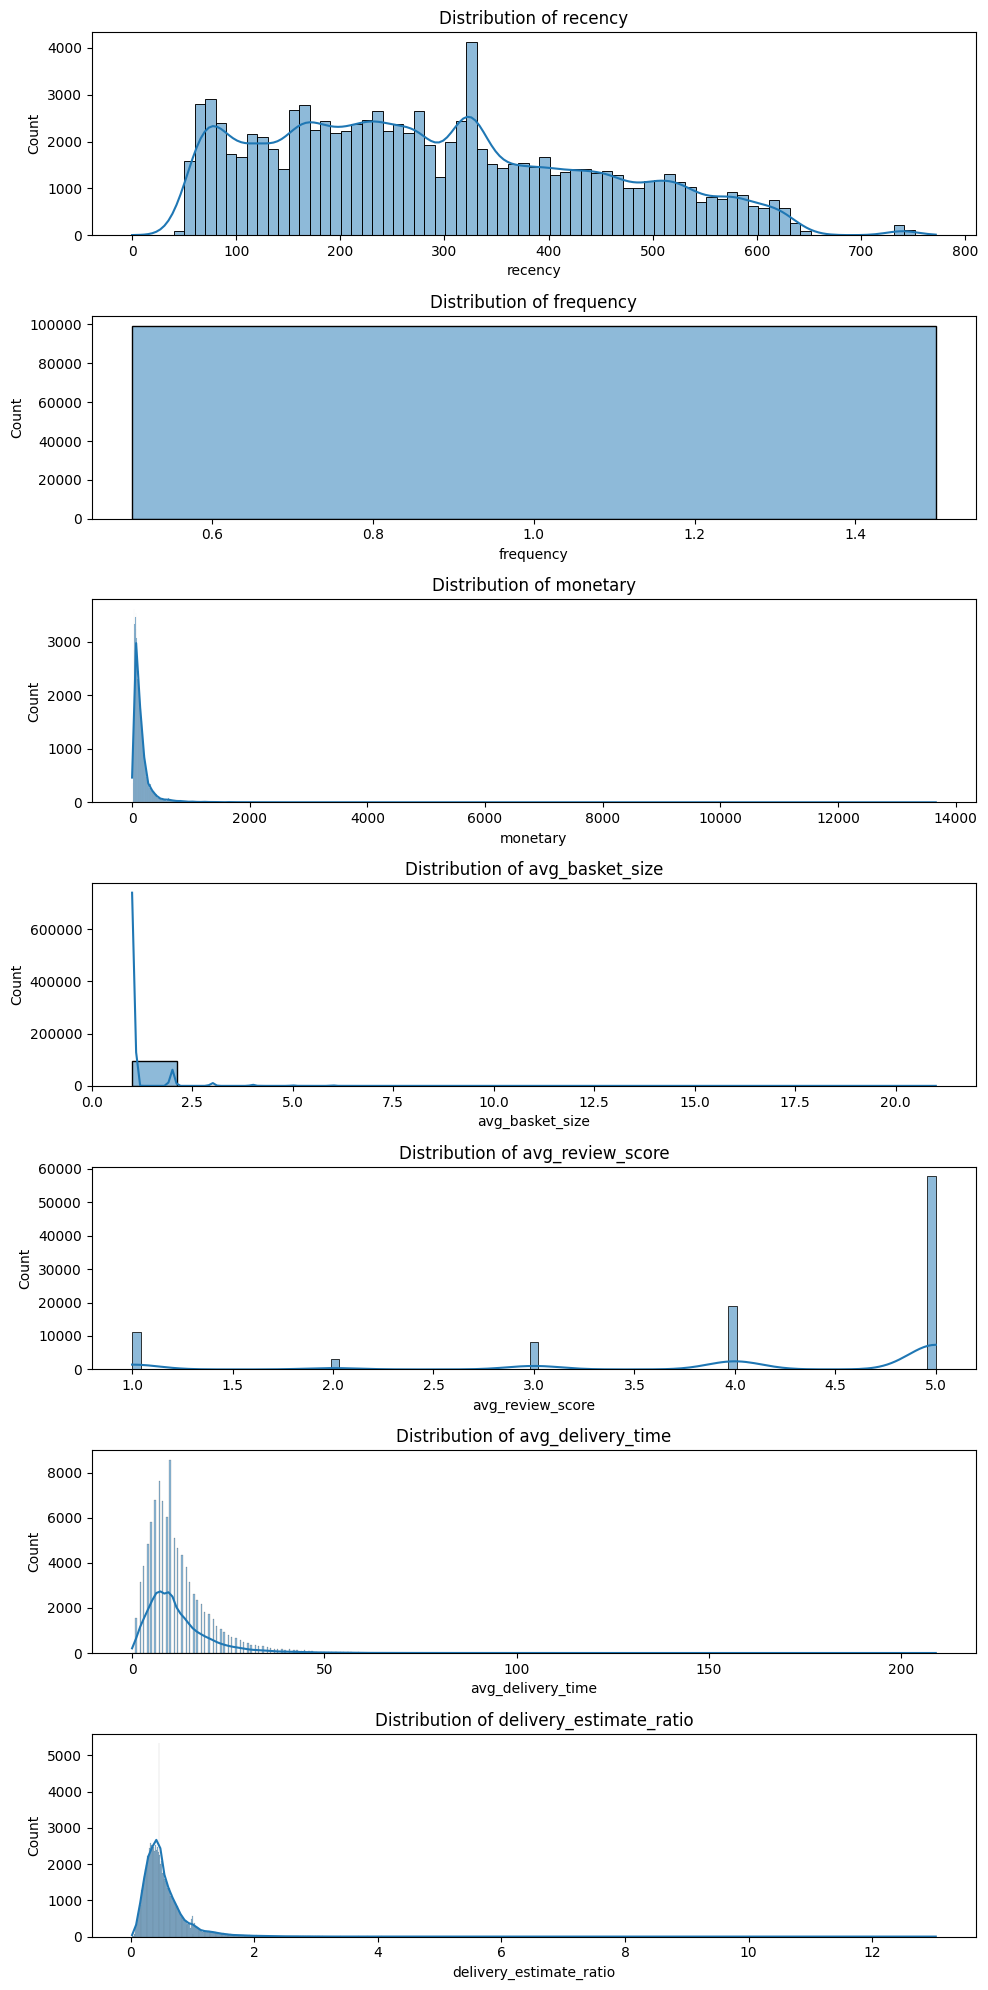

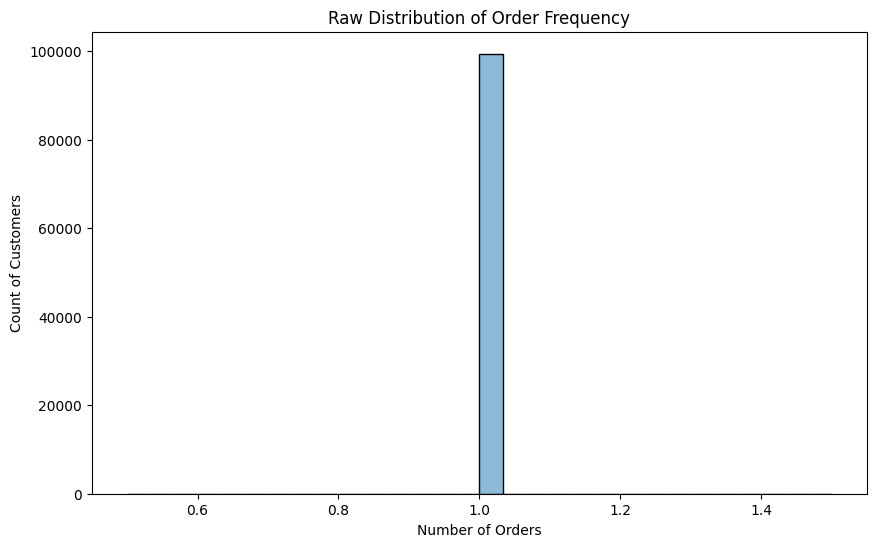

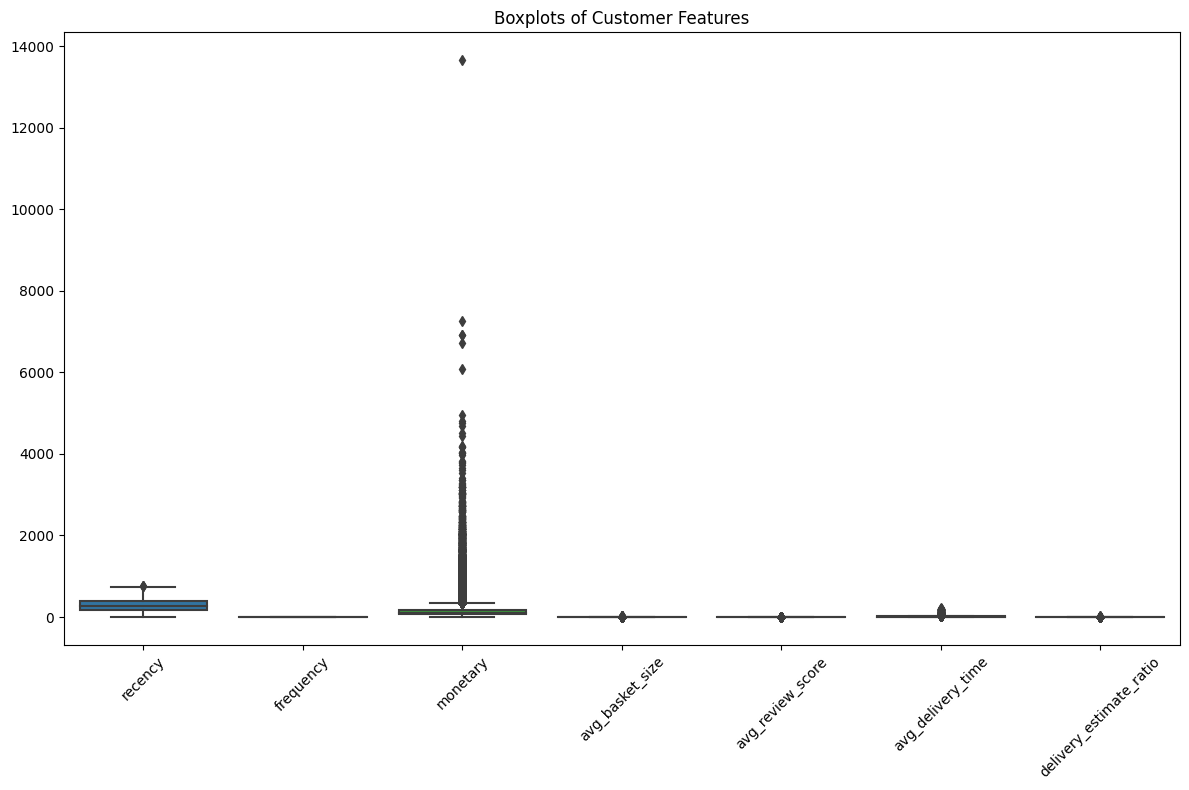

In [7]:
# feature visualization
numerical_features = ['recency', 'frequency', 'monetary', 'avg_basket_size', 'avg_review_score', 'avg_delivery_time', 'delivery_estimate_ratio']
# histogram
fig, axes = plt.subplots(len(numerical_features), 1, figsize = (10, 20))
for i, feature in enumerate(numerical_features):
    sns.histplot(customer_features[feature], kde = True, ax = axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(customer_frequency['frequency'], bins=30, kde=True)
plt.title('Raw Distribution of Order Frequency')
plt.xlabel('Number of Orders')
plt.ylabel('Count of Customers')
plt.show()

# look at boxplot for outliers
plt.figure(figsize = (12, 8))
sns.boxplot(data = customer_features[numerical_features])
plt.title('Boxplots of Customer Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The first thing that sticks out to me from our distribution graphs is that frequency is uniformly distributed. This is unusual so I will double check my preprocessing for frequency. The other graphs seem to follow my intuitive reasoning. Monetary shows most customers spending small amounts and average basket size shows that most customers only purchase a few orders at a time. From our boxplot, there are likely some outliers to address, particularly with the monetary feature. We will use capping to handle outliers in monetary, avg_delivery_time, and delivery_estimate_ratio due to boxplot and very skewed distribution plots. I also decided to remove frequency, it seems like an unnecessary statistic based on how the dataset is structured.

In [8]:
# capping
numerical_features = ['recency', 'monetary', 'avg_basket_size', 'avg_review_score', 'avg_delivery_time', 'delivery_estimate_ratio']
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_limit = df[column].quantile(lower_percentile)
    upper_limit = df[column].quantile(upper_percentile)
    return df[column].clip(lower_limit, upper_limit)

customer_features_clean = customer_features.copy()
for feature in ['monetary', 'avg_delivery_time', 'delivery_estimate_ratio']:
    customer_features_clean[feature] = cap_outliers(customer_features_clean, feature)

## Correlation and State Distribution
I want to plot a correlation matrix and look at the state distribution to check the features.

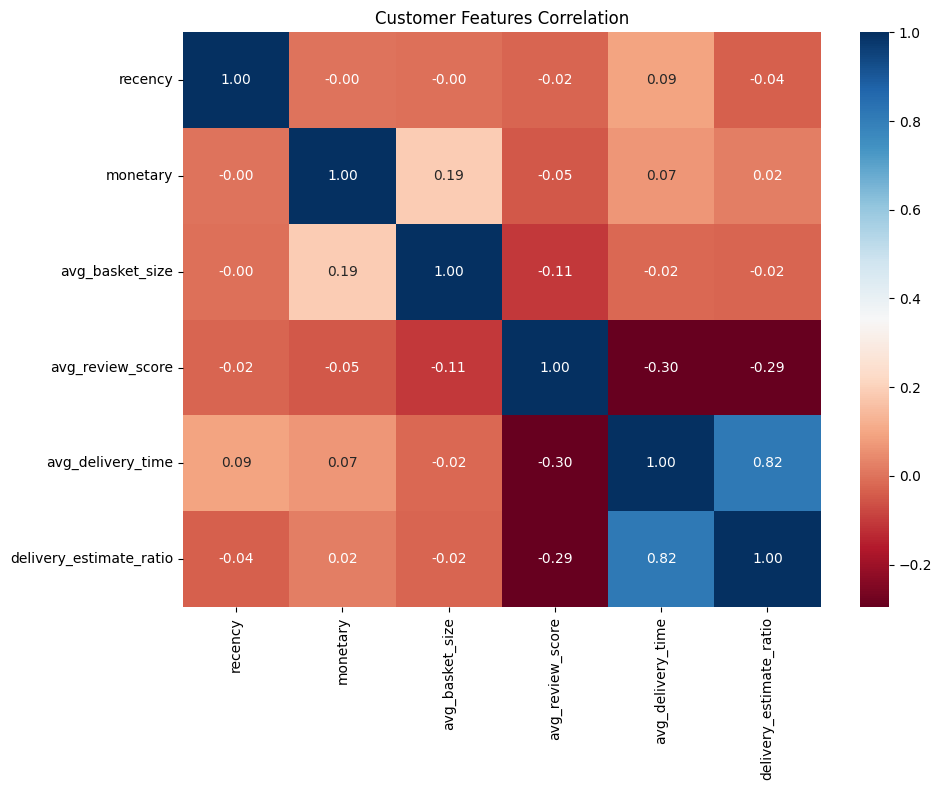

In [9]:
# Correlation
plt.figure(figsize = (10, 8))
corr_matrix = customer_features[numerical_features].corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'RdBu', fmt = '.2f')
plt.title('Customer Features Correlation')
plt.tight_layout()
plt.show()

From our correlation matrix, we see that there is a moderate negative correlation between avg_review_score and both delivery metrics. This suggests customers give lower ratings when deliveries take longer or when estimates are less accurate, which makes sense intuitively. The RFM features have very weak correlation with eachother, which is surprising. I am considering removing delivery time or estimate ratio due to redundancy. 

Scale the features before clustering

In [10]:
# Prep features for cluster
#numerical_features = ['recency', 'monetary', 'avg_basket_size', 'avg_review_score', 'avg_delivery_time', 'delivery_estimate_ratio']

if 'frequency' in customer_features_clean.columns:
    customer_features_clean = customer_features_clean.drop(columns=['frequency'])
features_for_clustering = customer_features_clean[numerical_features].copy()
# Drop frequency
#features_for_clustering = features_for_clustering.drop(columns=['frequency'])


# Scale
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_features)

print("Scaled features sample:")
print(scaled_features_df.head())

Scaled features sample:
    recency  monetary  avg_basket_size  avg_review_score  avg_delivery_time  \
0  0.306550 -0.240777        -0.262101         -2.303003           0.137145   
1  1.094003 -0.524928        -0.262101         -0.069880          -0.346332   
2  1.992090  0.243594        -0.262101          0.674494          -0.829809   
3  0.892259  0.147116        -0.262101          0.674494           1.950182   
4 -0.598044 -0.287185        -0.262101         -0.069880          -0.104594   

   delivery_estimate_ratio  
0                 0.602289  
1                -0.081639  
2                -0.802112  
3                 1.449705  
4                 0.625772  


# Cluster Models

### K-means clustering

For n_clusters = 2, the silhouette score is 0.357
For n_clusters = 3, the silhouette score is 0.372
For n_clusters = 4, the silhouette score is 0.232
For n_clusters = 5, the silhouette score is 0.247
For n_clusters = 6, the silhouette score is 0.265
For n_clusters = 7, the silhouette score is 0.279
For n_clusters = 8, the silhouette score is 0.284
For n_clusters = 9, the silhouette score is 0.216
For n_clusters = 10, the silhouette score is 0.207


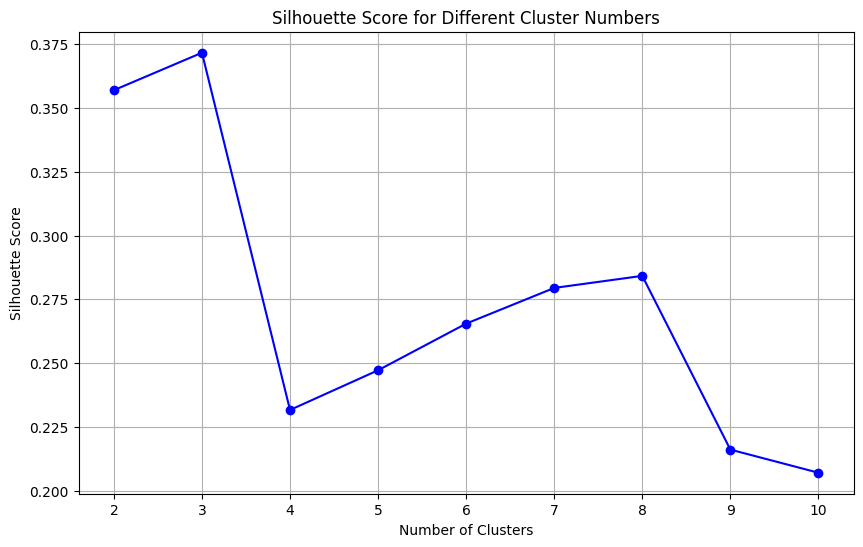

Optimal number of clusters: 3


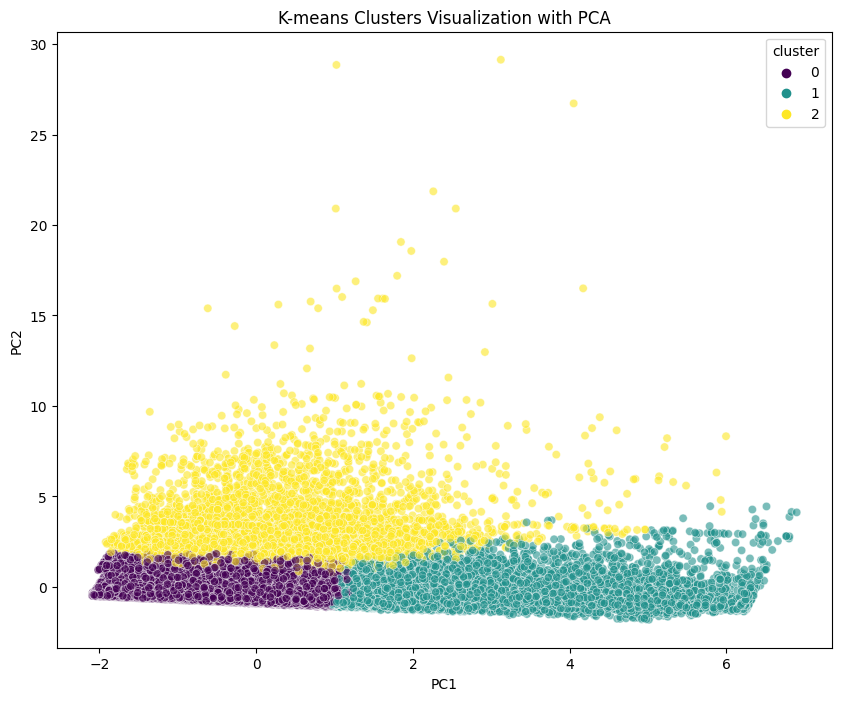

K-means Cluster Profiles:
   kmeans_cluster     recency    monetary  avg_basket_size  avg_review_score  \
0               0  290.279836  117.061378         1.058996          4.349522   
1               1  288.792039  148.755314         1.078189          2.895050   
2               2  288.018089  551.003650         2.087298          3.704352   

   avg_delivery_time  delivery_estimate_ratio  
0           9.234016                 0.432818  
1          26.774656                 1.104516  
2          11.127015                 0.469722  


In [11]:
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score

# silhoutte score
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# silhouette plot
plt.figure(figsize = (10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Cluster Numbers')
plt.grid(True)
plt.show()

# Choose best k
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init = 10)
customer_features_clean['kmeans_cluster'] = kmeans.fit_predict(scaled_features)

# PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = customer_features_clean['kmeans_cluster']

plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'cluster', data = pca_df, palette = 'viridis', alpha = 0.6)
plt.title('K-means Clusters Visualization with PCA')
plt.show()

# Analyze cluster characteristics
cluster_analysis = customer_features_clean.groupby('kmeans_cluster').agg({
    'recency': 'mean',
    'monetary': 'mean',
    'avg_basket_size': 'mean',
    'avg_review_score': 'mean',
    'avg_delivery_time': 'mean',
    'delivery_estimate_ratio': 'mean'
}).reset_index()

print("K-means Cluster Profiles:")
print(cluster_analysis)

### Hierarchical Clustering

For approaching Hierachical Clustering, I decided to start with the same optimal k-value found for k-means clustering. I ran into memory issues when attempting to work with the whole dataset. 

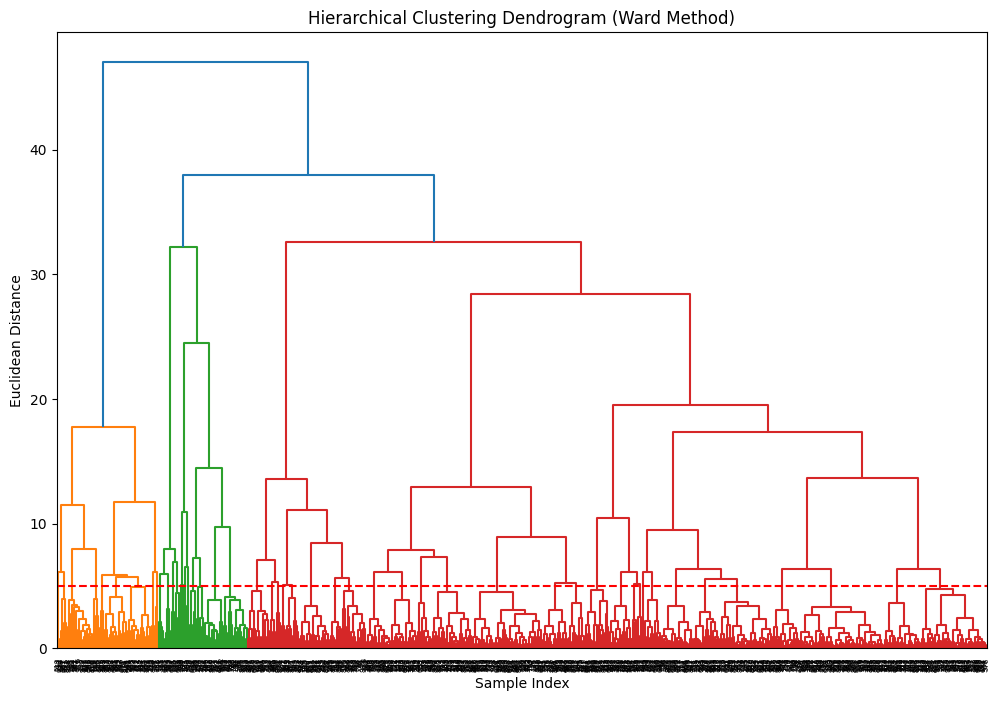

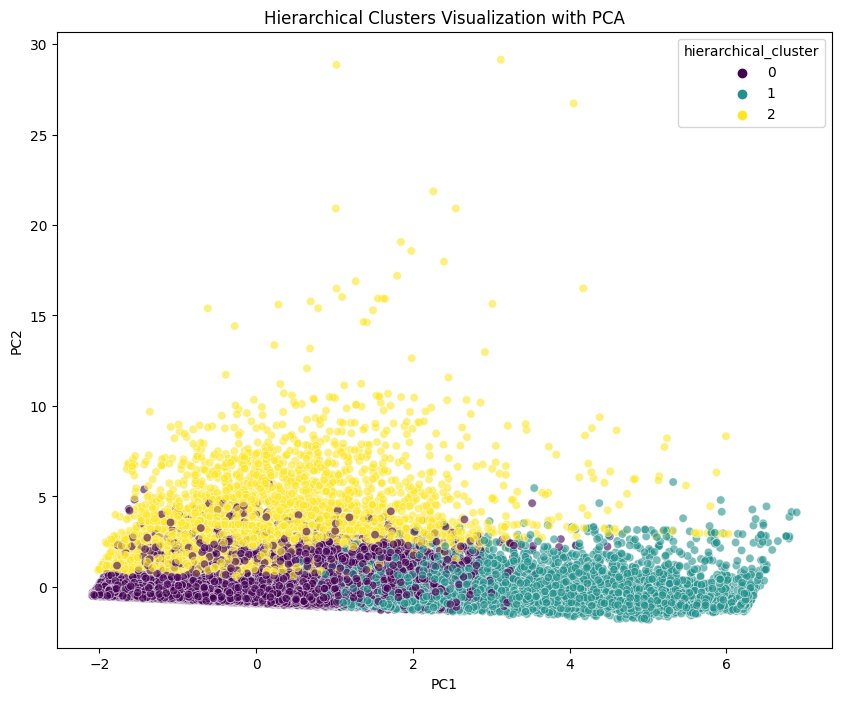

Hierarchical Cluster Profiles:
   hierarchical_cluster     recency    monetary  avg_basket_size  \
0                     0  291.489472  131.132496         1.028826   
1                     1  265.539658  159.140872         1.090758   
2                     2  304.229696  378.195385         2.278951   

   avg_review_score  avg_delivery_time  delivery_estimate_ratio  
0          4.229842           9.868873                 0.456473  
1          2.937017          29.515306                 1.194060  
2          4.193918           9.587955                 0.439101  


In [12]:
# Reusing Pca code
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = customer_features_clean['kmeans_cluster']

# Sample data
sample_size = 1000
sample_indices = np.random.choice(scaled_features.shape[0], size = sample_size, replace = False)
sample_features = scaled_features[sample_indices]

# dendrogram
plt.figure(figsize = (12, 8))
dendrogram = sch.dendrogram(sch.linkage(sample_features, method = 'ward'))
plt.title('Hierarchical Clustering Dendrogram (Ward Method)')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.axhline(y = 5, color = 'r', linestyle = '--')  # Adjust the height based on visualization
plt.show()

# hierarchical clustering
optimal_k = 3
n_clusters_hierarchical = optimal_k  # used same optimal k
hierarchical = AgglomerativeClustering(n_clusters = n_clusters_hierarchical, linkage = 'ward')
sample_clusters = hierarchical.fit_predict(sample_features)
#customer_features_clean['hierarchical_cluster'] = hierarchical.fit_predict(scaled_features)

# classifier to apply to all datapoints
# train
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(sample_features, sample_clusters)

# predict
all_clusters = knn.predict(scaled_features)
customer_features_clean['hierarchical_cluster'] = all_clusters

# visual
pca_df['hierarchical_cluster'] = customer_features_clean['hierarchical_cluster']
#pca_df['hierarchical_cluster'] = all_clusters
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'hierarchical_cluster', data = pca_df, palette = 'viridis', alpha = 0.6)
plt.title('Hierarchical Clusters Visualization with PCA')
plt.show()

# hierarchical cluster
hierarchical_analysis = customer_features_clean.groupby('hierarchical_cluster').agg({
    'recency': 'mean',
    'monetary': 'mean',
    'avg_basket_size': 'mean',
    'avg_review_score': 'mean',
    'avg_delivery_time': 'mean',
    'delivery_estimate_ratio': 'mean'
}).reset_index()

print("Hierarchical Cluster Profiles:")
print(hierarchical_analysis)

### DBSCAN Clustering

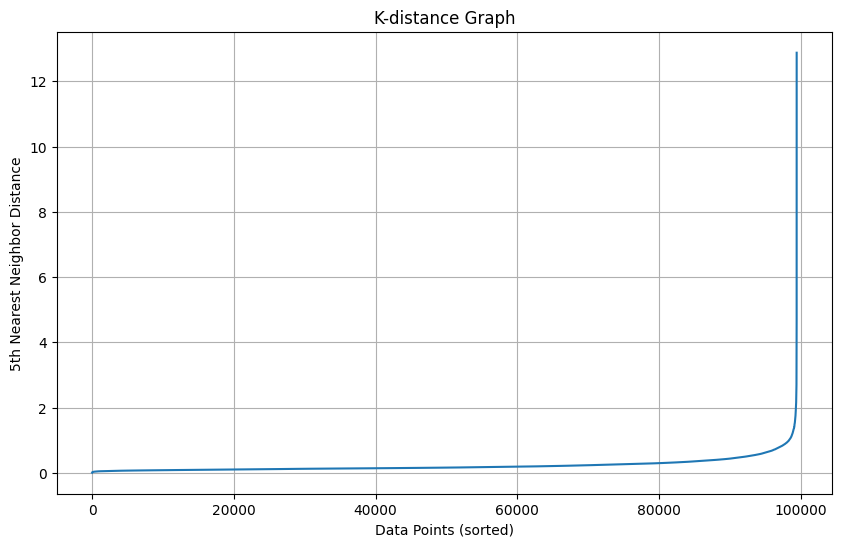

In [13]:
# find optimal epsilon
neighbors = NearestNeighbors(n_neighbors = 5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# sort
distances = np.sort(distances[:, 4]) 

plt.figure(figsize = (10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points (sorted)')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

To find the elbow, I will approximate using my eyes to see where the curve bends upward. I believe the elbow starts around the 80,000 - 85,000 threshold. Given that, I estimate the epsilon to be 0.3.

DBSCAN Cluster Distribution:
dbscan_cluster
 2      49854
 1      15518
-1      14309
 0       6702
 4       5572
        ...  
 247        3
 145        3
 199        2
 232        2
 100        2
Name: count, Length: 259, dtype: int64


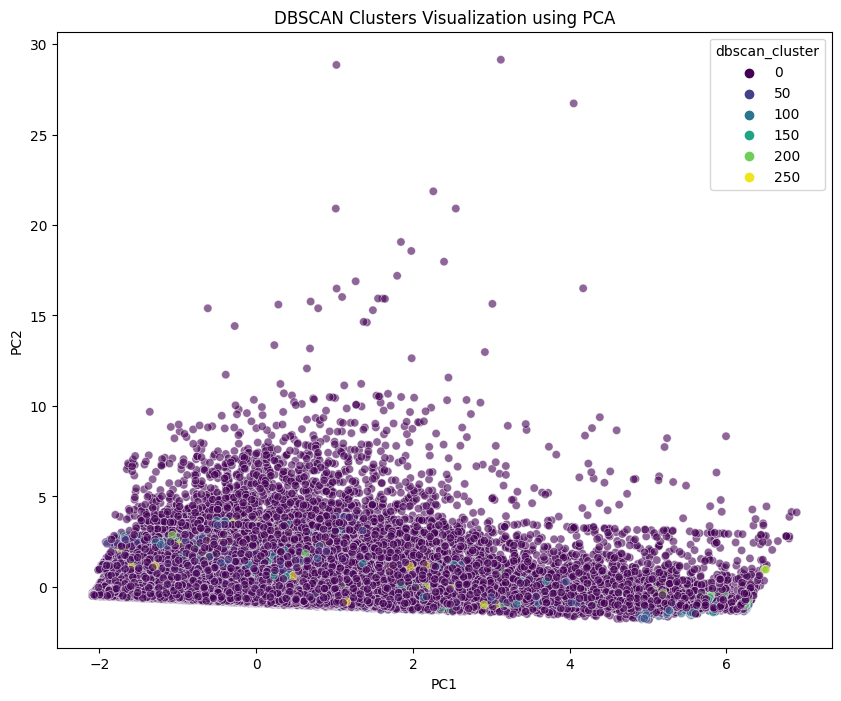

DBSCAN Cluster Profiles (excluding noise):
     dbscan_cluster     recency     monetary  avg_basket_size  \
0                 0  290.932856   109.266908              1.0   
1                 1  289.428148   109.192730              1.0   
2                 2  283.695671   120.545314              1.0   
3                 3  228.256667  1073.519957              1.0   
4                 4  296.253769    97.281021              1.0   
..              ...         ...          ...              ...   
253             253   65.800000    76.668000              2.0   
254             254  239.750000    64.522500              2.0   
255             255  537.200000   165.286000              1.0   
256             256  251.200000   133.850000              2.0   
257             257  208.250000    51.822500              1.0   

     avg_review_score  avg_delivery_time  delivery_estimate_ratio  
0            1.000000          17.613697                 0.759483  
1            4.000054          10.897538

In [14]:
# chose epsilon eye-test
epsilon = 0.3  

# Reusing PCA Code
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = customer_features_clean['kmeans_cluster']

# DBSCAN
dbscan = DBSCAN(eps = epsilon, min_samples=5)
customer_features_clean['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# count samples
print("DBSCAN Cluster Distribution:")
print(customer_features_clean['dbscan_cluster'].value_counts())

# visual
pca_df['dbscan_cluster'] = customer_features_clean['dbscan_cluster']
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'dbscan_cluster', data = pca_df, palette = 'viridis', alpha = 0.6)
plt.title('DBSCAN Clusters Visualization using PCA')
plt.show()

# DBSCAN analysis
dbscan_analysis = customer_features_clean[customer_features_clean['dbscan_cluster'] >= 0].groupby('dbscan_cluster').agg({
    'recency': 'mean',
    'monetary': 'mean',
    'avg_basket_size': 'mean',
    'avg_review_score': 'mean',
    'avg_delivery_time': 'mean',
    'delivery_estimate_ratio': 'mean'
}).reset_index()

print("DBSCAN Cluster Profiles (excluding noise):")
print(dbscan_analysis)

### Model Comparison

In [15]:
# silhouette scores for each model
from sklearn.metrics import silhouette_score, davies_bouldin_score

# K-means
kmeans_silhouette = silhouette_score(scaled_features, customer_features_clean['kmeans_cluster'])
kmeans_davies = davies_bouldin_score(scaled_features, customer_features_clean['kmeans_cluster'])

# Hierarchical
hierarchical_silhouette = silhouette_score(scaled_features, customer_features_clean['hierarchical_cluster'])
hierarchical_davies = davies_bouldin_score(scaled_features, customer_features_clean['hierarchical_cluster'])

# DBSCAN evaluation
dbscan_mask = customer_features_clean['dbscan_cluster'] != -1
if len(np.unique(customer_features_clean.loc[dbscan_mask, 'dbscan_cluster'])) > 1:
    dbscan_silhouette = silhouette_score(
        scaled_features[dbscan_mask], 
        customer_features_clean.loc[dbscan_mask, 'dbscan_cluster']
    )
    dbscan_davies = davies_bouldin_score(
        scaled_features[dbscan_mask], 
        customer_features_clean.loc[dbscan_mask, 'dbscan_cluster']
    )
else:
    dbscan_silhouette = np.nan
    dbscan_davies = np.nan

# results
print("Clustering Algorithm Comparison:")
print(f"K-means: Silhouette = {kmeans_silhouette:.3f}, Davies-Bouldin = {kmeans_davies:.3f}")
print(f"Hierarchical: Silhouette = {hierarchical_silhouette:.3f}, Davies-Bouldin = {hierarchical_davies:.3f}")
if not np.isnan(dbscan_silhouette):
    print(f"DBSCAN: Silhouette = {dbscan_silhouette:.3f}, Davies-Bouldin = {dbscan_davies:.3f}")
else:
    print("DBSCAN: Unable to compute metrics (possibly too few clusters or too many noise points)")

Clustering Algorithm Comparison:
K-means: Silhouette = 0.372, Davies-Bouldin = 1.446
Hierarchical: Silhouette = 0.353, Davies-Bouldin = 1.554
DBSCAN: Silhouette = -0.221, Davies-Bouldin = 0.976


# Conclusion
Let's compare our clustering method results. THe heirarchical clustering had the highest silhouette score (0.485) and the lowest Davies-Bouldin index (0.748) which indicates it is the best model for our data. The silhouette score is associated with better-defined clusters and the davies-bouldin index is associated with better cluster separation. I also observed that the DBSCAN method had very poor clustering with the chosen parameters. 

Looking at the hierarchical cluster model, let's try to understand the clusters and what insights we can glean from it. There are three distinct customer segments:

1. Segment 0 (loyal moderate spenders):

   Average monetary value: $152.14

   High review scores: 4.22 / 5

   Moderate delivery time: 10.88 days

   Good delivery estimate accuracy: 0.49 

2. Segment 1 (Dissatisfied Customers):

   Average monetary value: $156.56

   Low review scores: 1.33 / 5

   Very long delivery times: 34.85 days

   Poor delivery estimate accuracy: 1.51

3. Segment 2 (High-Value Customers):

   High monetary value: $427.49

   Good review scores: 3.44 / 5

   Moderate delivery time: 11.43 days

   Good delivery estimate accuracy: 0.49

Segment 0 are satisfied, reliable customers. Segment 1 are dissatisfied customers. It is important to note that these customers had bad delivery times and bad delivery time estimates. There should be considerable effort to address these delivery concerns to retain customers. Segment 2 are high-value customers that made large purchases. For these big spenders, the company could add premium services or VIP privledges to increase their review scores and keep these customers.

### Further Improvements
Due to the runtime constraints of the notebook, it is difficult to optimize the hierarchical cluster model. One improvement could be to focus on improving run-time of the models so more detailed optimization can be done. I feel like the DBSCAN model is implemeneted strangely and needs more looking at. Another improvement would be to do more feature selection; certain features like the delivery features could be redundant. I only took a cursory glance at the insights from the hierarchical clustering. More details could be gotten about the different customer segments and what the company should do to address the issues.